# Dataset

In [1]:
model_type = 'convnet' # baseline, resnet, resnet_pretrained, convnet
restart_scheduler = 5
merge_test = False

In [2]:
import sys
sys.path.append('../../datasets/')
from prepare_individuals import prepare, germanBats
import matplotlib.pyplot as plt

classes = germanBats

2022-11-04 11:19:35.730844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:19:36.173766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 11:19:38.727462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-11-04 11:19:38.727757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [3]:
num_bands = 257
seq_len = 60
patch_len = 61 * 2816      # = 250ms ~ 25ms (0.5 * 44 * (512 // 4))
patch_skip = 15 * 2816          # 15 patches = 15 * 0.25 * 22050 * 0.5

resize = None

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../../datasets/prepared_signal.h5", germanBats, patch_len, patch_skip, mode='slide', resize=None)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 19.93it/s]


In [4]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 19194
(11323, 171776) (11323,)


In [5]:
print("Total sequences:", len(X_test))
print(X_test.shape, Y_test.shape)

Total sequences: 4980
(4980, 171776) (4980,)


In [6]:
print("Total sequences:", len(X_val))
print(X_val.shape, Y_val.shape)

Total sequences: 2891
(2891, 171776) (2891,)


# Model
Sequence -> Feature map -> pos. encoding -> Transformer (CLS)

In [7]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models.feature_extraction import create_feature_extractor

sys.path.append('../addons/')
from sam import SAM
import einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torchsummary import summary
from torchmetrics.functional import f1_score

In [8]:
use_sampler = False
use_reduceonplateu = False
use_cosinescheduler = True
use_sam = True

In [9]:
'''from torchsummary import summary

# in: 64, 1343, 257 (b, w, h)
patch_embedding = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 1), padding=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
    nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 1)),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=(3, 2)),

    nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=5, stride=1, padding=1),

    nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1),
    
    nn.Flatten(),
    nn.Linear(128, num_classes),
).cuda()
summary(patch_embedding, (1, 1343, 257))'''

'from torchsummary import summary\n\n# in: 64, 1343, 257 (b, w, h)\npatch_embedding = nn.Sequential(\n    nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 1), padding=3),\n    nn.BatchNorm2d(16),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),\n    \n    nn.Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 1)),\n    nn.BatchNorm2d(16),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=3, stride=2),\n    \n    nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)),\n    nn.BatchNorm2d(32),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=3, stride=(3, 2)),\n\n    nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=1),\n    nn.BatchNorm2d(32),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=5, stride=1, padding=1),\n\n    nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)),\n    nn.BatchNorm2d(64),\n    nn.ReLU(),\n    nn.MaxPool2d(kernel_size=3, stride=1, padding=1),\n\n    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),\n    nn.BatchNorm2d(128),\n    nn.ReLU(),\

In [21]:
from torchsummary import summary

# in: 64, 1343, 257 (b, w, h)
patch_embedding = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 2), padding=3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    
    nn.Conv2d(16, 16, kernel_size=(7, 7), stride=(4, 2)),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 2), padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=5, stride=1, padding=1),

    nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 2)),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1, padding=(1, 1)),
    
    nn.Flatten(),
    nn.Linear(64, 18),
).cuda()
summary(patch_embedding, (1, 1343, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 336, 129]             800
       BatchNorm2d-2         [-1, 16, 336, 129]              32
              ReLU-3         [-1, 16, 336, 129]               0
         MaxPool2d-4          [-1, 16, 168, 65]               0
            Conv2d-5           [-1, 16, 41, 30]          12,560
       BatchNorm2d-6           [-1, 16, 41, 30]              32
              ReLU-7           [-1, 16, 41, 30]               0
         MaxPool2d-8           [-1, 16, 20, 14]               0
            Conv2d-9             [-1, 32, 6, 6]          12,832
      BatchNorm2d-10             [-1, 32, 6, 6]              64
             ReLU-11             [-1, 32, 6, 6]               0
        MaxPool2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 64, 1, 1]          18,496
      BatchNorm2d-14             [-1, 6

In [22]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        patch_dim,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        classifier_dropout=0.1,
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 2), padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(16, 16, kernel_size=(7, 7), stride=(4, 2)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=1),

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=(1, 1)),

            nn.Flatten(),
            nn.Linear(64, 18),
            # more linear layers + dropout
        )

    def forward(self, x):
        x = torch.abs(torch.stft(x, n_fft=512, window=torch.hann_window(window_length=512).cuda(), return_complex=True))
        x = 20 * torch.log10(x / torch.max(x))
        flt = torch.ones(list(x.shape)).cuda()
        flt[:, :int(257 * (15000 / 120000)), :] = 0
        x = x * flt
        x = torch.abs(x - x.mean(dim=2, keepdim=True).repeat((1, 1, x.shape[2])))
        x = x.transpose(dim0=2, dim1=1)
        x[torch.isinf(x)] = 0
        x[torch.isnan(x)] = 0
        
        x = self.cnn(x.unsqueeze(1))
        return x

In [23]:
import random

def one_hot(x, num_classes, on_value=1., off_value=0., device='cuda'):
    x = x.long().view(-1, 1)
    return torch.full((x.size()[0], num_classes), off_value, device=device).scatter_(1, x, on_value)

def rand_y(Y, exclude_class):
    while True:
        idx = random.randint(0, len(Y)-1)
        if torch.logical_and(Y[idx], exclude_class).sum() == 0:
            return idx

# X and Y need to be shuffled
def mixup(X, Y, num_classes, min_seq=2, max_seq=2):
    Y1 = one_hot(Y, num_classes, device=X.device)
    X2 = X.clone()
    Y2 = Y1.clone()
    for i, y in enumerate(Y):
        rand_k = random.randint(min_seq, max_seq)
        for k in range(rand_k-1):
            idx = rand_y(Y1, Y2[i])
            X2[i] += X[idx] #.squeeze()
            Y2[i] += Y1[idx] #.squeeze()
        X2[i] /= rand_k
    return X2, Y2

def getCorrects(output, target):
    n_targets = target.sum(dim=1).int().cpu().detach().numpy()
    best_2 = torch.zeros_like(output)
    for i, e in enumerate(torch.argsort(output, 1)):
        best_2[i, e[-n_targets[i]:]] = 1
    log_and = torch.logical_and(best_2, target)
    corr = 0.0
    for i, t in enumerate(target):
        corr += log_and[i].sum() / max(t.sum(), output[i].sum())
    return corr

In [24]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(inputs)

        # Compute Loss
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        if use_sam:
            optimizer.first_step()
            criterion(model(inputs), labels).backward()
            optimizer.second_step()
        else:
            optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += getCorrects(outputs, labels)
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [25]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)
            inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += getCorrects(outputs, labels)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [26]:
from torchsampler import ImbalancedDatasetSampler

max_len = seq_len
batch_size = 64
epochs = 23
lr = .0005
warmup_epochs = 5
if model_type == "convnet":
    d_model = 64
else:
    d_model = 512
    

nhead = 2
dim_feedforward = 32
num_layers = 2
dropout = 0.3
classifier_dropout = 0.3
num_classes = len(list(classes))

if merge_test:
    X_train = np.concatenate((X_train, X_test), axis=0)
    Y_train = np.concatenate((Y_train, Y_test), axis=0)
    X_test = X_val
    Y_test = Y_val
    
train_len = batch_size * int(len(X_train) / batch_size)
test_len = batch_size * int(len(X_test) / batch_size)
val_len = batch_size * int(len(X_val) / batch_size)
train_data = TensorDataset(torch.Tensor(X_train[:train_len]), torch.from_numpy(Y_train[:train_len]))
test_data = TensorDataset(torch.Tensor(X_test[:test_len]), torch.from_numpy(Y_test[:test_len]))
val_data = TensorDataset(torch.Tensor(X_val[:val_len]), torch.from_numpy(Y_val[:val_len]))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

torch.Size([64, 60, 44, 257])


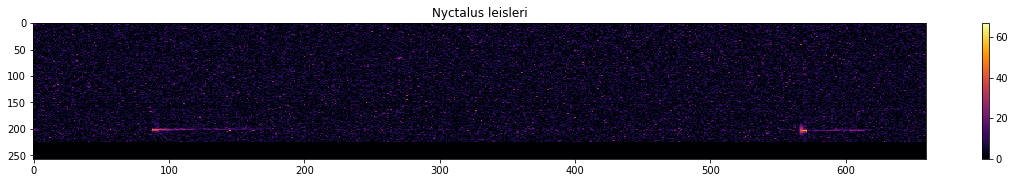

In [27]:
def signalToPatches(x):
    x = torch.abs(torch.stft(x, n_fft=512, window=torch.hann_window(window_length=512), return_complex=True))
    x = 20 * torch.log10(x / torch.max(x)) # 10 * torch.log10(x**2 / torch.max(x**2))
    flt = torch.ones(list(x.shape))
    flt[:, :int(257 * (15000 / 120000)), :] = 0
    x = x * flt
    x = torch.abs(x - x.mean(dim=2, keepdim=True).repeat((1, 1, x.shape[2])))
    x = x.transpose(dim0=2, dim1=1)
    x = x.unfold(dimension=1, size=44, step=22).permute((0, 1, 3, 2)) # Col2Im
    x[torch.isinf(x)] = 0
    x[torch.isnan(x)] = 0
    print(x.shape)
    return x

def stitch(a, r):
    return a[::r]
  
def plot_sequence(seq, y):
    plt.figure(figsize = (20, 2.5))
    stitched = stitch(seq, int(patch_len / patch_skip))
    spec = np.rot90(np.concatenate(stitched))
    plt.imshow(spec, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.colorbar()
    label_list = []
    if(len(y.shape) > 0):
        for i in np.argwhere(y == 1)[:,0]:
            label_list.append(list(classes)[i])
        plt.title(", ".join(label_list))
    else:
        plt.title(list(classes)[y])

k = random.randint(0, batch_size)
X1, Y1 = next(iter(train_loader))
X1, Y1 = mixup(X1, Y1, num_classes=num_classes, min_seq=1, max_seq=3)
X1_p = signalToPatches(X1)
plot_sequence(X1_p[k].detach().numpy(), Y1[k].detach().numpy())

In [28]:
model = Net(
    max_len=max_len,
    patch_dim=resize[0]*resize[1] if resize is not None else patch_len * num_bands, # patch_len * num_bands, # 44 * 257 = 11,308
    d_model=d_model,
    num_classes=len(list(classes)),
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    num_layers=num_layers,
    dropout=dropout,
    classifier_dropout=classifier_dropout,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model, device_ids=[0, 1])
    
model.to(device)
print(device)

cuda:0


In [29]:
import wandb
from losses import AsymmetricLoss

wandb_config = {
    "epochs": epochs,
    "lr": lr,
    "batch_size": batch_size,
    "warmup_epochs": warmup_epochs,
    "d_model": d_model,
    "nhead": nhead,
    "dim_feedforward": dim_feedforward,
    "num_layers": num_layers,
    "dropout": dropout,
    "classifier_dropout": classifier_dropout,
    
    "use_sampler": use_sampler,
    "use_reduceonplateu": use_reduceonplateu,
    "use_cosinescheduler": use_cosinescheduler,
    "use_sam": use_sam,
    "mege_test": merge_test
}

wandb.init(project="BAT-2-mixed", entity="frankfundel", config=wandb_config)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2/16), weight=torch.tensor(100)) # contains sigmoid
#criterion = AsymmetricLoss(gamma_neg=0, gamma_pos=0, clip=0, disable_torch_grad_focal_loss=True)
#criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=2, clip=0, disable_torch_grad_focal_loss=True)
criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0, disable_torch_grad_focal_loss=True)


if use_sam:
    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frankfundel (use `wandb login --relogin` to force relogin)


In [30]:
num_classes = len(list(classes))
s_epoch = 0
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, s_epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, s_epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
        
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_2_' + model_type + '_mixed.pth')
    
    if s_epoch == restart_scheduler:
        s_epoch = 0
    else:
        s_epoch += 1

==================== Starting at epoch 0 ====================


  0%|                                                   | 0/176 [00:00<?, ?it/s]2022-11-04 11:31:06.976076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:31:07.397130: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  4%|█▋                                         | 7/176 [00:04<01:41,  1.67it/s]2022-11-04 11:31:10.241009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ffundel/.local/lib:
2022-11-04 11:31:10.241290

Training loss: 107.0945 Acc: 0.5076



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.47it/s]

Validation loss: 101.3501 Acc: 0.5469
val_loss decreased, saving model
==================== Starting at epoch 1 ====================



100%|█████████████████████████████████████████| 176/176 [01:16<00:00,  2.29it/s]

Training loss: 84.0123 Acc: 0.6465



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.73it/s]

Validation loss: 84.8369 Acc: 0.6623
val_loss decreased, saving model
==================== Starting at epoch 2 ====================



100%|█████████████████████████████████████████| 176/176 [01:15<00:00,  2.32it/s]

Training loss: 75.4757 Acc: 0.6938



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.76it/s]

Validation loss: 76.0061 Acc: 0.6928
val_loss decreased, saving model
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 176/176 [01:16<00:00,  2.29it/s]

Training loss: 71.4272 Acc: 0.7163



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.56it/s]

Validation loss: 71.7823 Acc: 0.7167
val_loss decreased, saving model
==================== Starting at epoch 4 ====================



100%|█████████████████████████████████████████| 176/176 [01:18<00:00,  2.25it/s]

Training loss: 69.7899 Acc: 0.7273



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.70it/s]

Validation loss: 72.2311 Acc: 0.7067
==================== Starting at epoch 5 ====================



100%|█████████████████████████████████████████| 176/176 [01:16<00:00,  2.30it/s]

Training loss: 73.2238 Acc: 0.7064



100%|███████████████████████████████████████████| 45/45 [00:11<00:00,  3.84it/s]

Validation loss: 78.4275 Acc: 0.6832
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 176/176 [01:19<00:00,  2.23it/s]

Training loss: 69.9584 Acc: 0.7217



100%|███████████████████████████████████████████| 45/45 [00:12<00:00,  3.50it/s]

Validation loss: 72.7806 Acc: 0.6983
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 176/176 [01:20<00:00,  2.19it/s]

Training loss: 66.7930 Acc: 0.7367



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.43it/s]

Validation loss: 74.0719 Acc: 0.7053
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 176/176 [01:27<00:00,  2.00it/s]

Training loss: 64.3907 Acc: 0.7518



100%|███████████████████████████████████████████| 45/45 [00:15<00:00,  2.97it/s]

Validation loss: 69.4780 Acc: 0.7266
val_loss decreased, saving model
==================== Starting at epoch 9 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  1.98it/s]

Training loss: 60.9402 Acc: 0.7711



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.13it/s]

Validation loss: 65.2091 Acc: 0.7480
val_loss decreased, saving model
==================== Starting at epoch 10 ====================



100%|█████████████████████████████████████████| 176/176 [01:29<00:00,  1.97it/s]

Training loss: 60.9570 Acc: 0.7713



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.18it/s]

Validation loss: 67.6234 Acc: 0.7406
==================== Starting at epoch 11 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  2.00it/s]

Training loss: 64.8264 Acc: 0.7498



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.42it/s]

Validation loss: 86.4572 Acc: 0.6712
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  1.99it/s]

Training loss: 63.8213 Acc: 0.7609



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.14it/s]

Validation loss: 70.1340 Acc: 0.7150
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  2.00it/s]

Training loss: 62.1447 Acc: 0.7657



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.14it/s]

Validation loss: 71.4527 Acc: 0.7131
==================== Starting at epoch 14 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  1.98it/s]

Training loss: 59.7405 Acc: 0.7824



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.13it/s]

Validation loss: 66.6817 Acc: 0.7580
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████| 176/176 [01:27<00:00,  2.01it/s]

Training loss: 57.7515 Acc: 0.7894



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.17it/s]

Validation loss: 63.0614 Acc: 0.7666
val_loss decreased, saving model
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 176/176 [01:28<00:00,  1.99it/s]

Training loss: 56.5093 Acc: 0.7998



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.09it/s]

Validation loss: 62.9868 Acc: 0.7686
val_loss decreased, saving model
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 176/176 [01:25<00:00,  2.06it/s]

Training loss: 59.9874 Acc: 0.7809



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.02it/s]

Validation loss: 85.6539 Acc: 0.6865
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 176/176 [01:24<00:00,  2.07it/s]

Training loss: 60.0134 Acc: 0.7776



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]

Validation loss: 71.6164 Acc: 0.7285
==================== Starting at epoch 19 ====================



100%|█████████████████████████████████████████| 176/176 [01:25<00:00,  2.05it/s]

Training loss: 58.6234 Acc: 0.7866



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.37it/s]

Validation loss: 76.1803 Acc: 0.6863
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 176/176 [01:24<00:00,  2.09it/s]

Training loss: 57.0771 Acc: 0.7923



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.37it/s]

Validation loss: 68.1322 Acc: 0.7486
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 176/176 [01:24<00:00,  2.08it/s]

Training loss: 54.4992 Acc: 0.8061



100%|███████████████████████████████████████████| 45/45 [00:13<00:00,  3.32it/s]

Validation loss: 62.9625 Acc: 0.7651
val_loss decreased, saving model
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 176/176 [01:27<00:00,  2.02it/s]

Training loss: 53.6506 Acc: 0.8107



100%|███████████████████████████████████████████| 45/45 [00:14<00:00,  3.13it/s]

Validation loss: 61.3834 Acc: 0.7710
val_loss decreased, saving model


In [31]:
model.load_state_dict(torch.load('bat_2_' + model_type + '_mixed.pth'))
#compiled_model = torch.jit.script(model)
#torch.jit.save(compiled_model, 'bat_1.pt')

<All keys matched successfully>

In [32]:
mixed_corrects = 0.0
repeats = 5

predictions = []
targets = []

for r in range(repeats):
    # iterate over test data
    for inputs, labels in tqdm.tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = mixup(inputs, labels, num_classes=num_classes, min_seq=1, max_seq=3)

        output = model(inputs) # Feed Network
        predictions.extend(output.data.cpu().numpy())
        targets.extend(labels.data.cpu().numpy())
        mixed_corrects += getCorrects(output, labels)

100%|███████████████████████████████████████████| 77/77 [00:27<00:00,  2.85it/s]


In [33]:
from sklearn.metrics import f1_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

test_acc = mixed_corrects / (repeats * len(test_data))
f1_micro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='micro')
f1_macro = f1_score(sigmoid(np.asarray(predictions)) > 0.5, np.asarray(targets), average='macro')

print("Mixed test acc:", test_acc)
print("Mixed f1 micro:", f1_micro)
print("Mixed f1 macro:", f1_macro)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params, "params")

Mixed test acc: tensor(0.7620, device='cuda:0')
Mixed f1 micro: 0.7409127789046653
Mixed f1 macro: 0.637207037512946
46114 params


In [34]:
wandb.log({
    "test_acc": test_acc,
    "f1_micro": f1_micro,
    "f1_macro": f1_macro,
    "num_params": pytorch_total_params,
})

In [35]:
wandb.finish()

f1_macro,▁
f1_micro,▁
num_params,▁
test_acc,▁
train_acc,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇███
train_loss,█▅▄▃▃▄▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁
val_acc,▁▅▆▆▆▅▆▆▇▇▇▅▆▆███▅▇▅▇██
val_loss,█▅▄▃▃▄▃▃▂▂▂▅▃▃▂▁▁▅▃▄▂▁▁
f1_macro,0.63721
f1_micro,0.74091
num_params,46114


In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
    output = model(inputs.cuda()) # Feed Network

    output = torch.argmax(output, 1).data.cpu().numpy()
    Y_pred.extend(output) # Save Prediction

    #labels = torch.argmax(labels, 1).data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    Y_true.extend(labels) # Save Truth

100%|███████████████████████████████████████████| 77/77 [00:14<00:00,  5.47it/s]


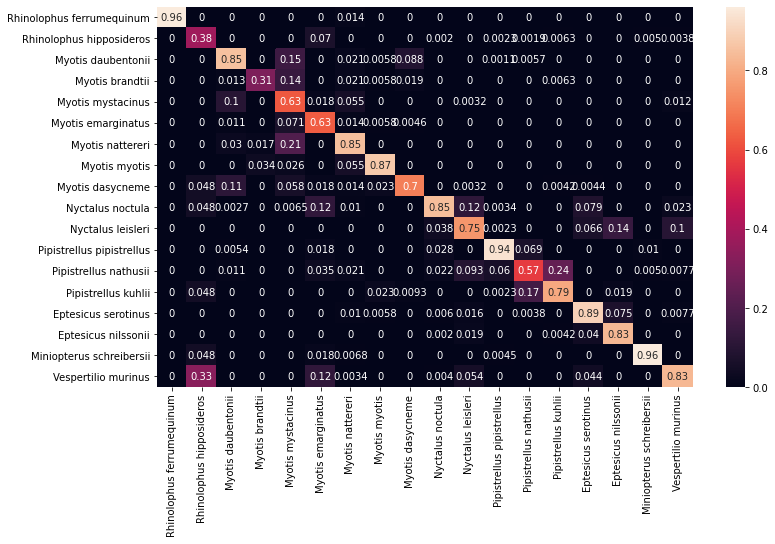

In [37]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_2_' + model_type + '_mixed_cf.png')

In [38]:
import sklearn
corrects = np.equal(Y_pred, Y_true).sum()
test_acc = corrects/len(Y_pred)
f1 = sklearn.metrics.f1_score(Y_true, Y_pred, average=None).mean()
print("Test accuracy:", test_acc)
print("F1-score:", f1)

Test accuracy: 0.8076298701298701
F1-score: 0.7584442231898048
